In [1]:
import os
import pandas as pd
import utils as utils

DATA_PATH = '../../backend/data/database/'

In [2]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(72, 8)

In [3]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
25,60cb07e335a3ead69def5309,human,5.0,R635,L937,R135,L094,finished
21,608b1ac239a12b93a41241bb,human,2.0,L872,R768,R909,L047,finished
48,65bd62059011c29003340f83,human,5.0,L029,L437,R136,R024,finished
17,60185c812e31c90cbd82f28c,placebo,3.0,R376,L291,L430,R888,finished
39,62babccea6f10f16ce6a5a75,human,1.0,R552,R669,L614,L654,finished
41,64532687f92beccab874da1c,placebo,2.0,R372,R879,L991,L458,finished
59,6679757dcf5a0a996e500673,placebo,5.0,R382,L764,R518,L572,finished
49,66072bcf065f7722b6e6ec0c,human,3.0,R151,L894,R186,L092,finished
29,6109d27d098c1da473759897,human,5.0,L231,R969,R775,L600,finished
4,5c508d4ec150bc0001ff2de0,machine,NaN,R932,L636,R433,L746,started


In [4]:
qualif_participants = participants_df.loc[participants_df['ParticipantStatus']=='finished'].reset_index(drop=True)
qualif_participants.shape

(66, 8)

In [5]:
qualif_participants['PoliticalLeaning'].value_counts()

PoliticalLeaning
3.0    23
2.0    16
5.0     9
4.0     6
8.0     5
6.0     4
1.0     2
7.0     1
Name: count, dtype: int64

<Axes: xlabel='PoliticalLeaning'>

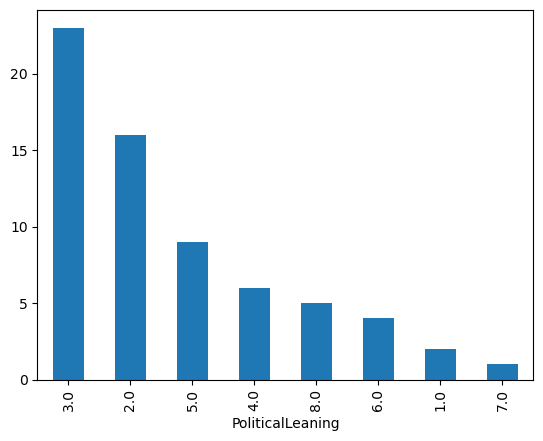

In [6]:
qualif_participants['PoliticalLeaning'].value_counts().plot.bar()

In [7]:
qualif_participants['TreatmentGroup'].value_counts()

TreatmentGroup
placebo    23
human      22
machine    21
Name: count, dtype: int64

<Axes: xlabel='TreatmentGroup'>

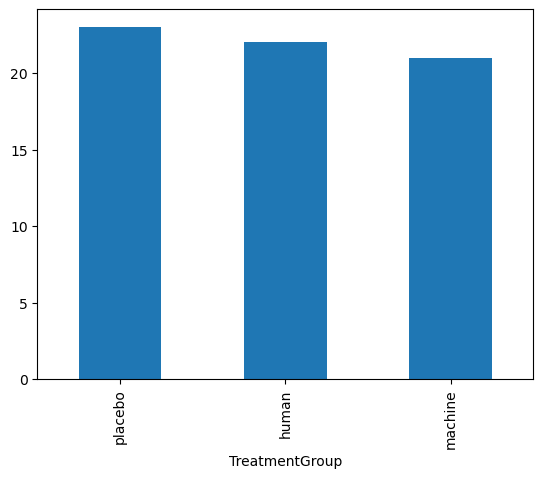

In [8]:
qualif_participants['TreatmentGroup'].value_counts().plot.bar()

In [9]:
answers_df = pd.read_parquet(os.path.join(DATA_PATH, 'answers.parquet'))
answers_df.shape

(266, 10)

In [10]:
answers_df.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
159,64e932db43d288f41267bb87T4,64e932db43d288f41267bb87,6711d315ec8d941dbd4c170f,ML582,L582,2.0,5.0,4.0,1.0,73
204,6658e0603e414aa496b0cc7eT4,6658e0603e414aa496b0cc7e,671615da13aa9cb321f1a8a7,L929,PL929,4.0,1.0,4.0,1.0,264
259,6717500cc1636e190512f0abT2,6717500cc1636e190512f0ab,671bccbb4934018e3545f77f,R990,MR990,5.0,2.0,4.0,1.0,38
94,60cca61928c85ab4cb85fa71T3,60cca61928c85ab4cb85fa71,671e31d418793e93ee64b30e,L619,HL619,4.0,4.0,4.0,1.0,89
16,5d160cd4e639230001e95fc0T1,5d160cd4e639230001e95fc0,672dedd82c4731d9f83557dd,R171,HR171,5.0,1.0,4.0,1.0,96
193,664cc91532e124f91fce47e8T1,664cc91532e124f91fce47e8,67115774f82f70440aecb6eb,MR836,R836,1.0,5.0,4.0,2.0,87
68,606f10d6a7f29420571b07ccT1,606f10d6a7f29420571b07cc,6716aa33135f76179eced3c9,HR442,R442,2.0,4.0,5.0,2.0,62
234,66b3ace64c9b2e3f3dc2a60bT1,66b3ace64c9b2e3f3dc2a60b,6716151132d6a67b7bc47bee,MR327,R327,2.0,5.0,1.0,2.0,110
185,66451a9f8be668feb7d3d240T1,66451a9f8be668feb7d3d240,6711cbdda22f0638a3f69524,R438,MR438,4.0,4.0,5.0,3.0,144
31,5e95bbc06074fb0008bc60faT4,5e95bbc06074fb0008bc60fa,67150cd2aaea0a4d2956bc29,R473,PR473,4.0,4.0,4.0,3.0,47


In [11]:
qualif_answers = answers_df.loc[answers_df['FK_ParticipantId'].isin(qualif_participants['ParticipantId'].values)].reset_index(drop=True)
qualif_answers.shape

(264, 10)

In [12]:
qualif_answers.head(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
0,57bb0ebfd4654c00018e0261T1,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR749,R749,4.0,5.0,5.0,2.0,44
1,57bb0ebfd4654c00018e0261T2,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,L167,ML167,3.0,3.0,5.0,3.0,43
2,57bb0ebfd4654c00018e0261T3,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR050,R050,2.0,5.0,4.0,2.0,58
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64
4,5ab848ffe1546900019b6ec9T1,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L211,ML211,5.0,2.0,4.0,1.0,59
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55
6,5ab848ffe1546900019b6ec9T3,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,MR942,R942,4.0,5.0,2.0,2.0,66
7,5ab848ffe1546900019b6ec9T4,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,R528,MR528,4.0,2.0,4.0,1.0,40
8,5c131126d6d169000148414aT1,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,PL159,L159,4.0,4.0,5.0,1.0,59
9,5c131126d6d169000148414aT2,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,L482,PL482,4.0,4.0,4.0,3.0,21


In [13]:
new_values = []

for idx, row in qualif_answers.iterrows():
    treated_polar, treated_likert, original_polar, original_likert = utils.get_polar_info(row)
    treated_less_polar = utils.is_treated_less_polar(row)
    diff_likert_treated_original = utils.get_treat_diff(row)
    tweet_bias = utils.get_tt_bias(row['Text1'])
    participant_leaning = int(qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['PoliticalLeaning'].values[0])
    treatment_group = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['TreatmentGroup'].values[0]
    new_values.append(
        {
            'TreatedIsPolarized' : treated_polar,
            'TreatedLikertValue' : treated_likert,
            'OriginalIsPolarized' : original_polar,
            'OriginalLikertValue' : original_likert,
            'TreatedIsLessPolar' : treated_less_polar,
            'DiffLikertTreatedOriginal' : diff_likert_treated_original,
            'TweetBias' : tweet_bias,
            'ParticipantLeaning' : participant_leaning,
            'TreatmentGroup' : treatment_group
        }
    )

In [14]:
new_columns = pd.DataFrame.from_records(new_values)
new_columns.sample(5)

,TreatedIsPolarized,TreatedLikertValue,OriginalIsPolarized,OriginalLikertValue,TreatedIsLessPolar,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
219,1,5,1,5,1,0,L,5,placebo
226,1,4,1,4,0,0,L,5,placebo
194,1,5,1,5,1,0,R,3,machine
139,1,4,1,5,1,0,R,3,machine
84,0,2,1,4,1,-1,L,3,placebo


In [15]:
answers_data = pd.concat([qualif_answers, new_columns], axis=1)
answers_data.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent,TreatedIsPolarized,TreatedLikertValue,OriginalIsPolarized,OriginalLikertValue,TreatedIsLessPolar,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
163,64ff77269d93d4c79f8a58c5T4,64ff77269d93d4c79f8a58c5,6720356185ff15254cff6c2b,MR751,R751,3.0,3.0,4.0,3.0,25,-1,3,-1,3,0,0,R,2,machine
257,6717500cc1636e190512f0abT2,6717500cc1636e190512f0ab,671bccbb4934018e3545f77f,R990,MR990,5.0,2.0,4.0,1.0,38,0,2,1,5,1,-2,R,5,machine
244,66ccf8abf9e250aa74ab1d3fT1,66ccf8abf9e250aa74ab1d3f,672ca6a6249de4f50ff42e37,R227,HR227,5.0,5.0,4.0,1.0,99,1,5,1,5,1,1,R,5,human
221,667d9e3136e04a629c3f290dT2,667d9e3136e04a629c3f290d,6711ab6a8c924db7e485e820,HL719,L719,2.0,5.0,4.0,2.0,58,0,2,1,5,1,-3,L,3,human
152,6478e0af8c176315633328e0T1,6478e0af8c176315633328e0,67116de02c0c273189b769ff,MR406,R406,4.0,5.0,5.0,2.0,48,1,4,1,5,1,-1,R,5,machine
193,664cc91532e124f91fce47e8T2,664cc91532e124f91fce47e8,67115774f82f70440aecb6eb,L884,ML884,5.0,1.0,4.0,1.0,56,0,1,1,5,1,-3,L,3,machine
56,60185c812e31c90cbd82f28cT1,60185c812e31c90cbd82f28c,67124dac9e2123793aee0047,PR376,R376,4.0,5.0,4.0,2.0,57,1,4,1,5,1,-1,R,3,placebo
168,65941845194f617bc81f2dacT1,65941845194f617bc81f2dac,6717753437e6a7a61bef6086,R509,PR509,5.0,5.0,5.0,3.0,40,1,5,1,5,0,0,R,2,placebo
137,62696b4c3d25b18ffff47d0dT2,62696b4c3d25b18ffff47d0d,672e9438cfb08e24e0ee5b4e,R847,MR847,5.0,2.0,4.0,1.0,214,0,2,1,5,1,-2,R,3,machine
20,5d98d9971e667f00171f82e9T1,5d98d9971e667f00171f82e9,67115a94c0f683068cf68379,MR623,R623,2.0,4.0,4.0,2.0,98,0,2,1,4,1,-2,R,5,machine


In [16]:
answers_data.to_parquet(os.path.join(DATA_PATH, 'survey_data.parquet'), index=False)
answers_data.to_csv(os.path.join(DATA_PATH, 'survey_data.csv'), index=False)

In [24]:
answers_data.loc[answers_data['TreatmentGroup']=='machine']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    64
0    20
Name: count, dtype: int64

In [25]:
answers_data.loc[answers_data['TreatmentGroup']=='human']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    77
0    11
Name: count, dtype: int64

In [26]:
answers_data.loc[answers_data['TreatmentGroup']=='placebo']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
0    64
1    28
Name: count, dtype: int64